### Big Data Class Project 
### Analyze the effect Elon Musk's tweets on Tesla stock price.
    - Using data set available from kaggle
        - Elon Musk tweets from 2012 to 2017 https://www.kaggle.com/kulgen/elon-musks-tweets
            - This contains all tweets made by @elonmusk, his official Twitter handle, between 11/16/2012 and 09/29/2017.
        - Tesla stock price data https://www.kaggle.com/rpaguirre/tesla-stock-price
            - 06/29/2010 to 03/17/2017.

    - Special Library Used : TextBlob
        - pip install -U textblob
        - https://textblob.readthedocs.io/en/dev/install.html
#### Approach taken to correlate the two data sets.
    - Tweet
        - Clean tweet data and stock data.
        - Make sure both the data belong to a given date range. (May be not required)
        - Remove unwanted columns from the column.
            - Tweet -> remove 'user', 'row ID' -> not required.
        - Analyze tweets using TextBlob library.
        - Based on this analyses, categorize tweet as 'positive', 'negative' or neutral
        - Since there are multiple tweets in a day, get the maximum sentiment of the day and assign this to the day.

    - Stock data
        - Calculate the day's percent change. [(close_price-open_price)/(close_price)]*100
        - Merge Tweet and Stock data on 'Time' field.
            - Use inner merge, i.e consider only matching dates.

### Analysis:
    - Run machine learning on the merged/prepaired and calculate correlation between tweet sentiment and stock price change sentiment.
    - Used linear regression and random forest to develop the model.

### Conclusion:
    - As per the data, the model was not able to predict any correlation between Elon Musk's tweets and Tesla stock price changes.

In [2]:
import pandas as pd
import seaborn as sns
import datetime as datetime
from matplotlib import pyplot as plt
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from pandas.tseries.offsets import BDay


musk_tweets_data_file = '../input/elon-musks-tweets/data_elonmusk.csv'
tesla_stock_data_file = '../input/tesla-stock-price/Tesla.csv - Tesla.csv.csv'

tweets_df = pd.read_csv(musk_tweets_data_file, encoding='latin1')
tesla_stock_price_df = pd.read_csv(tesla_stock_data_file)

def clean_tweet(tweet):
    """ Utility function to clean tweet text by removing links, special characters using simple regex statements. """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)", " ", tweet).split())

# Return the polarity of the tweet using TextBlob analysis
def analyse_tweet(tweet):
    """ Utility function to classify sentiment of passed tweet using textblob's sentiment method """
    clean_tweet(tweet)
    # create TextBlob object of passed tweet text
    tweet_analysis = TextBlob(tweet)
    return tweet_analysis.sentiment.polarity

# Analyse tweet using TextBlob and categorize it as 'positive', 'negative' or 'neutral'
def get_tweet_sentiment(tweet):
    tweet_polarity = analyse_tweet(tweet)
    # set sentiment
    if tweet_polarity > 0:
        return 'positive'
    elif tweet_polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def filter_by_daterange(df):
    start_date = pd.to_datetime("2012-1-1").date()
    end_date = pd.to_datetime("2017-12-31").date()
    mask = (df['Time'] > start_date) & (df['Time'] <= end_date)
    df = df.loc[mask]
    #Filter only Business day
    isBusinessDay = BDay().onOffset
    match_series = pd.to_datetime(df['Time']).map(isBusinessDay)
    df[match_series]
    return df

def clean_tweet_data(tweets):
    # Drop unwanted columns
    tweets = tweets.drop('row ID',1)
    tweets = tweets.drop('User',1)
    # Convert 'Time' column to datetime and strip time information.
    tweets['Time'] = pd.to_datetime(tweets['Time']).dt.date
    # Consider only dates between a range
    tweets = filter_by_daterange(tweets)
    # Add sentiment of the tweet to the data.
    tweets['Sentiment'] = tweets.apply(lambda row : get_tweet_sentiment(row['Tweet']), axis=1)
    tweets_sentiment = tweets[['Time', 'Sentiment']].copy() 
    # Will consider maximum tweet sentiment as the sentiment of the day.
    tweets_sentiment = tweets_sentiment.groupby(tweets_sentiment.Time)\
                        .agg(lambda x: x.value_counts().index[0])
    tweets_sentiment.sort_values(by=['Time'], inplace=True)
    return tweets_sentiment

def clean_stock_data(stock_data):
    #Remove null stock data.
    stock_data = stock_data.dropna()
    #Convert 'Date' column to datetime and strip time information.
    stock_data['Time'] = pd.to_datetime(stock_data['Date']).dt.date
    stock_data = stock_data.drop('Date',1)
    #Consider only dates between a range
    stock_data = filter_by_daterange(stock_data)    
    #Calculate daily change percentage
    stock_data['daily_percentage_change'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open'] * 100
    stock_daily_change = stock_data[['Time', 'daily_percentage_change']].copy()
    stock_daily_change.sort_values(by=['Time'], inplace=True)
    return stock_daily_change

def merge_tweets_and_stock_data(tweets_sentiment_data, stock_price_change_data):
    #Combine two dataframes based on time.
    sentiment_stock_change_data = pd.merge(tweets_sentiment_data, stock_price_change_data, on='Time', how='inner')
    return sentiment_stock_change_data

def make_sentiment_column_categorical(tweet_sentiment_with_price_change):
    #Change 'Sentiment' column to categorical column.
    tweet_sentiment_with_price_change['Sentiment'] = tweet_sentiment_with_price_change['Sentiment'].astype('category')
    tweet_sentiment_with_price_change['Sentiment'] = tweet_sentiment_with_price_change['Sentiment'].cat.codes
    return tweet_sentiment_with_price_change

def do_linear_regression(X, Y):
    #Split data in train and test
    X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    # Train the model
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X_train, Y_train)
    # Calculate the r2_score (variance score) using sklearn linear_model.
    r2_score_1 = linear_regression_model.score(X, Y)
    # Predict stock change percentage with the trained model using test data.
    y_predicted = linear_regression_model.predict(x_test)
    # r2_score using sklearn metrics (1 is perfect prediction)
    r2_score_2 = r2_score(y_test, y_predicted)
    # Plot residuals of the data using seaborn residplot
    plt.figure(figsize=(15,4))
    sns.residplot(sentiment, price_change)
    plt.xlabel("Sentiment")
    plt.ylabel("Price change")
    plt.title("Residual Plot - Tweet Sentiment vs Tesla Price Change Percent using linear regression")
    plt.show()
    # Plot actual vs predicted stock price change from the model
    plt.figure(figsize=(15,4))
    plt.scatter(X, Y,  color='black')
    plt.plot(y_test, y_predicted, color='blue', linewidth=3)
    plt.xlabel("Sentiment")
    plt.ylabel("Stock Price Change Percent")
    plt.title("Scatter Plot - Tweet Sentiment vs Tesla Stock Price Change Percent using linear regression")
    plt.show()
    
    return r2_score_1, r2_score_2

def do_random_forest_analysis(X, Y):
    #Split data in train and test
    X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    #Train the model.
    random_forest_model = RandomForestRegressor()
    random_forest_model.fit(X_train, Y_train)
    #Calculate the r2 score by applying the model.
    r2_score_1 = random_forest_model.score(X, Y)
    # Predict stock change percentage with the trained model using test data.
    y_predicted = random_forest_model.predict(x_test)
    # r2_score using sklearn metrics (1 is perfect prediction)
    r2_score_2 = r2_score(y_test, y_predicted)
    # Plot residuals of the data using seaborn residplot
    plt.figure(figsize=(15,4))
    sns.residplot(sentiment, price_change)
    plt.xlabel("Sentiment")
    plt.ylabel("Price change")
    plt.title("Residual Plot - Tweet Sentiment vs Tesla Price Change Percent using Random Forest")
    plt.show()
    # Plot actual vs predicted stock price change from the model
    plt.figure(figsize=(15,4))
    plt.scatter(X, Y,  color='black')
    plt.plot(y_test, y_predicted, color='blue', linewidth=3)
    plt.xlabel("Sentiment")
    plt.ylabel("Stock Price Change Percent")
    plt.title("Scatter Plot - Tweet Sentiment vs Tesla Stock Price Change Percent using Random Forest")
    plt.show()
    return r2_score_1, r2_score_2

In [3]:
cleaned_tweets_with_sentiment = clean_tweet_data(tweets_df)
print(" Cleaned tweets count = ", cleaned_tweets_with_sentiment.Sentiment.count())

tesla_stock_with_daily_change = clean_stock_data(tesla_stock_price_df)
print("\n Stock price change data count = ", tesla_stock_with_daily_change.daily_percentage_change.count())

sentiment_stock_change_df = merge_tweets_and_stock_data(cleaned_tweets_with_sentiment, tesla_stock_with_daily_change)

positive_sentiment_stock_change_data = sentiment_stock_change_df.loc[sentiment_stock_change_df['Sentiment'] == 'positive']
negative_sentiment_stock_change_data = sentiment_stock_change_df.loc[sentiment_stock_change_df['Sentiment'] == 'negative']
neutral_sentiment_stock_change_data = sentiment_stock_change_df.loc[sentiment_stock_change_df['Sentiment'] == 'neutral']

print("\n Total number of days with sentiment value in tweets", sentiment_stock_change_df.Time.count())
print("\n No of days with positive tweet sentiment", positive_sentiment_stock_change_data.Time.count())
print("\n No of days with negative tweet sentiment", negative_sentiment_stock_change_data.Time.count())
print("\n No of days with neutral tweet sentiment", neutral_sentiment_stock_change_data.Time.count())

 Cleaned tweets count =  892

 Stock price change data count =  1310

 Total number of days with sentiment value in tweets 527

 No of days with positive tweet sentiment 215

 No of days with negative tweet sentiment 63

 No of days with neutral tweet sentiment 249


In [4]:
# Calculating the mean and standard deviation of the stock price change percentage per sentiment of tweets.
grouped_sentiment_stock_change = sentiment_stock_change_df.groupby(['Sentiment'], as_index=False)
mean_stock_price_change = grouped_sentiment_stock_change.mean()
stddev_stock_price_change = grouped_sentiment_stock_change['daily_percentage_change'].apply(lambda x: x.std())

print("\nMean of stock price change percent per sentiment")
print(mean_stock_price_change)

print("\nStddev stock price change percent per sentiment")
print(stddev_stock_price_change)


Mean of stock price change percent per sentiment
  Sentiment  daily_percentage_change
0  negative                 0.667277
1   neutral                 0.019097
2  positive                 0.068668

Stddev stock price change percent per sentiment
0    2.220034
1    2.517659
2    2.504832
dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


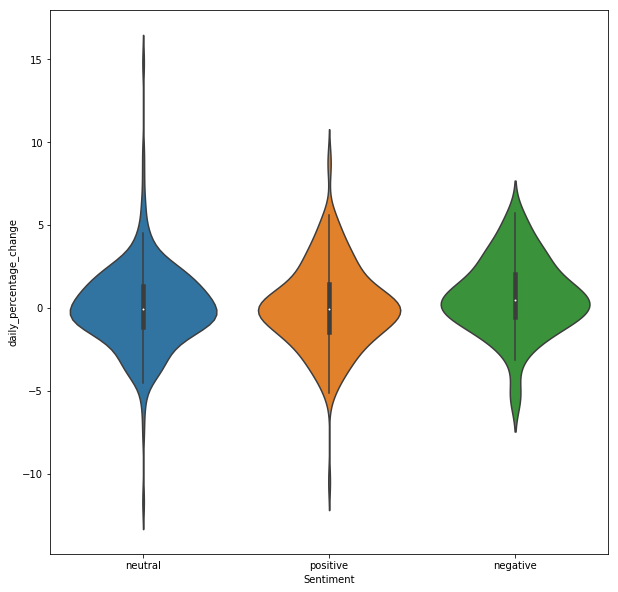

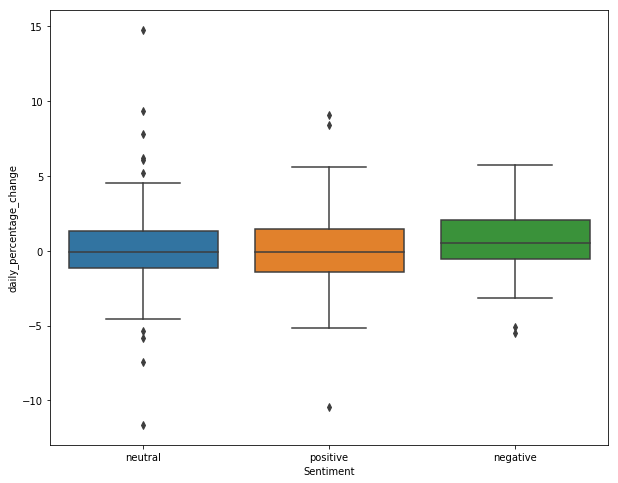

In [5]:
plt.figure(figsize=(10, 10))
sns.violinplot(x=sentiment_stock_change_df.Sentiment, y=sentiment_stock_change_df.daily_percentage_change, data=sentiment_stock_change_df, height=8)

# Ploting cholestrol data based on heart disease(ANYCHD).
plt.figure(figsize=(10, 8))
sns.boxplot(data=sentiment_stock_change_df, x=sentiment_stock_change_df.Sentiment, y=sentiment_stock_change_df.daily_percentage_change)

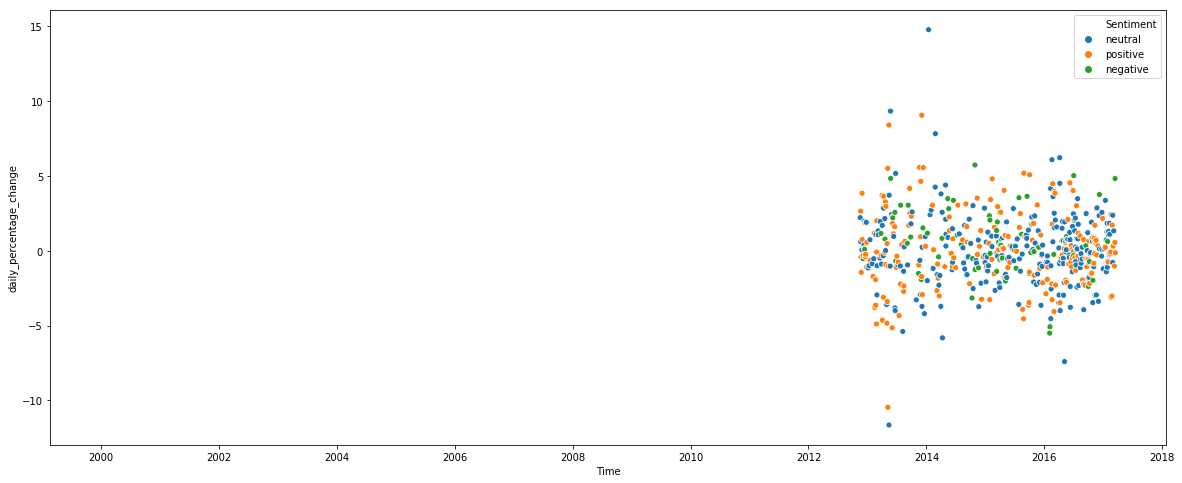

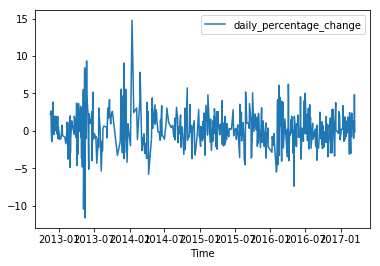

In [6]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=sentiment_stock_change_df['Time'], y=sentiment_stock_change_df['daily_percentage_change'], 
                data=sentiment_stock_change_df,hue=sentiment_stock_change_df['Sentiment']);

sentiment_stock_change_df[['Time', 'daily_percentage_change']].set_index('Time').plot()

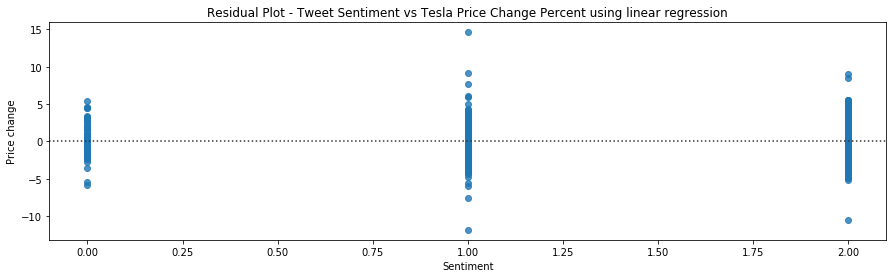

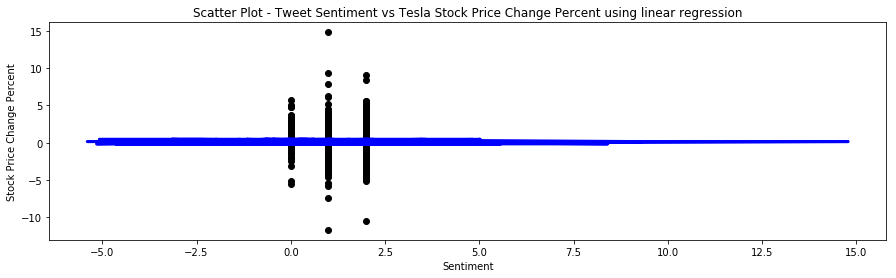

R2 (Variance) score using linear_regression model =  0.0013085238690396794
R2 (Variance) score using sklearn metrics with linear_regression =  -0.010992408041364587


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:130: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


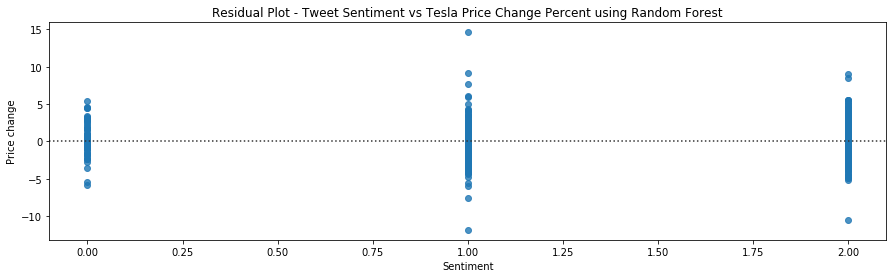

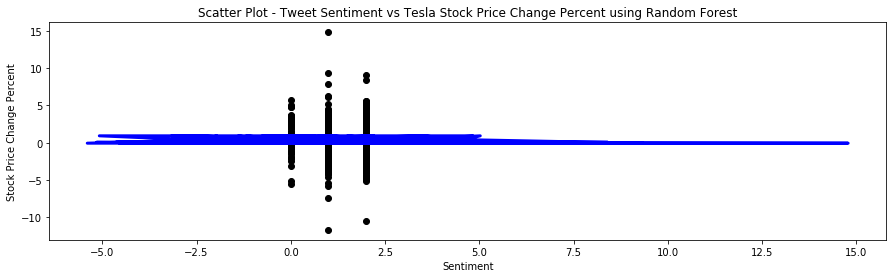

R2 (Variance) score using random forest model =  0.004993864384885471
R2 (Variance) score using sklearn metrics with random forest =  -0.01161703192359087


In [7]:
sentiment_stock_change_updated = make_sentiment_column_categorical(sentiment_stock_change_df)
sentiment = sentiment_stock_change_updated.Sentiment.values.reshape(-1, 1)
price_change = sentiment_stock_change_updated.daily_percentage_change.values.reshape(-1, 1)

r2_score_1, r2_score_2 = do_linear_regression(sentiment, price_change)
print('R2 (Variance) score using linear_regression model = ', r2_score_1)
print('R2 (Variance) score using sklearn metrics with linear_regression = ', r2_score_2)

r2_score_1, r2_score_2 = do_random_forest_analysis(sentiment, price_change)
print('R2 (Variance) score using random forest model = ', r2_score_1)
print('R2 (Variance) score using sklearn metrics with random forest = ', r2_score_2)